# Exploratory Data Analysis of [Full IMDb Movies Data](https://www.kaggle.com/datasets/anandshaw2001/imdb-data)

Install all necessary dependencies using pip

In [1]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'D:\магистратура 2025\1 курс\kafka\vasilisa\venv\Scripts\python.exe -m pip install --upgrade pip' command.


Import needed packages

In [2]:
import joblib
import kagglehub
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from tqdm import tqdm


D:\магистратура 2025\1 курс\kafka\vasilisa\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Download the original dataset from [Kaggle](https://www.kaggle.com/datasets/anandshaw2001/imdb-data)

In [3]:
original_datatest_path = kagglehub.dataset_download("anandshaw2001/imdb-data")
print(f"Original dataset path: {original_datatest_path}")

Original dataset path: C:\Users\bvasi\.cache\kagglehub\datasets\anandshaw2001\imdb-data\versions\1


In [4]:
original_dataset = pd.read_csv(
    f"{original_datatest_path}/Imdb Movie Dataset.csv",
    encoding="utf-8"
)
original_dataset.head()

,id,title,vote_average,vote_count,status,release_date,revenue,runtime,adult,budget,...,original_language,original_title,overview,popularity,tagline,genres,production_companies,production_countries,spoken_languages,keywords
0,27205,Inception,8.364,34495,Released,7/15/2010,825532764,148,False,160000000,...,en,Inception,"Cobb, a skilled thief who commits corporate es...",83.952,Your mind is the scene of the crime.,"Action, Science Fiction, Adventure","Legendary Pictures, Syncopy, Warner Bros. Pict...","United Kingdom, United States of America","English, French, Japanese, Swahili","rescue, mission, dream, airplane, paris, franc..."
1,157336,Interstellar,8.417,32571,Released,11/5/2014,701729206,169,False,165000000,...,en,Interstellar,The adventures of a group of explorers who mak...,140.241,Mankind was born on Earth. It was never meant ...,"Adventure, Drama, Science Fiction","Legendary Pictures, Syncopy, Lynda Obst Produc...","United Kingdom, United States of America",English,"rescue, future, spacecraft, race against time,..."
2,155,The Dark Knight,8.512,30619,Released,7/16/2008,1004558444,152,False,185000000,...,en,The Dark Knight,Batman raises the stakes in his war on crime. ...,130.643,Welcome to a world without rules.,"Drama, Action, Crime, Thriller","DC Comics, Legendary Pictures, Syncopy, Isobel...","United Kingdom, United States of America","English, Mandarin","joker, sadism, chaos, secret identity, crime f..."
3,19995,Avatar,7.573,29815,Released,12/15/2009,2923706026,162,False,237000000,...,en,Avatar,"In the 22nd century, a paraplegic Marine is di...",79.932,Enter the world of Pandora.,"Action, Adventure, Fantasy, Science Fiction","Dune Entertainment, Lightstorm Entertainment, ...","United States of America, United Kingdom","English, Spanish","future, society, culture clash, space travel, ..."
4,24428,The Avengers,7.710,29166,Released,4/25/2012,1518815515,143,False,220000000,...,en,The Avengers,When an unexpected enemy emerges and threatens...,98.082,Some assembly required.,"Science Fiction, Action, Adventure",Marvel Studios,United States of America,"English, Hindi, Russian","new york city, superhero, shield, based on com..."


Columns Description:
1. `id`: A unique identifier for each movie.
2. `title`: The name of the movie.
3. `vote_average`: The average rating the movie has received from users (on a scale, typically from 0 to 10).
4. `vote_count`: The total number of votes or ratings submitted for the movie.
5. `status`: The current state of the movie (e.g., "Released," "Post-Production").
6. `release_date`: The date when the movie was officially released.
7. `revenue`: The total earnings the movie made (usually in USD).
8. `runtime`: The duration of the movie in minutes.
9. `adult`: Indicates whether the movie is classified as adult content (e.g., "True" or "False").
10. `budget`: The total cost of producing the movie (usually in USD).
11. `imdb_id`: The unique identifier for the movie on IMDb (Internet Movie Database).
12. `original_language`: The language in which the movie was originally produced (e.g., "en" for English).
13. `original_title`: The original title of the movie in its native language.
14. `overview`: A brief summary or description of the movie's plot.
15. `popularity`: A metric indicating how popular the movie is (typically based on views, searches, or ratings).
16. `tagline`: A short phrase or slogan associated with the movie.
17. `genres`: The categories or genres the movie belongs to (e.g., Action, Comedy, Drama).
18. `production_companies`: The names of the companies involved in producing the movie.
19. `production_countries`: The countries where the movie was produced.
20. `spoken_languages`: The languages spoken in the movie.
21. `keywords`: Important terms or phrases associated with the movie, often used for categorization or search.

`vote_average` is the target column. To prepare the dataset for classification of the rating, convert the column to `int`

In [5]:
original_dataset['target'] = original_dataset['vote_average'].apply(int)
original_dataset.drop(columns=['vote_average'])

,id,title,vote_count,status,release_date,revenue,runtime,adult,budget,imdb_id,...,original_title,overview,popularity,tagline,genres,production_companies,production_countries,spoken_languages,keywords,target
0,27205,Inception,34495,Released,7/15/2010,825532764,148,False,160000000,tt1375666,...,Inception,"Cobb, a skilled thief who commits corporate es...",83.952,Your mind is the scene of the crime.,"Action, Science Fiction, Adventure","Legendary Pictures, Syncopy, Warner Bros. Pict...","United Kingdom, United States of America","English, French, Japanese, Swahili","rescue, mission, dream, airplane, paris, franc...",8
1,157336,Interstellar,32571,Released,11/5/2014,701729206,169,False,165000000,tt0816692,...,Interstellar,The adventures of a group of explorers who mak...,140.241,Mankind was born on Earth. It was never meant ...,"Adventure, Drama, Science Fiction","Legendary Pictures, Syncopy, Lynda Obst Produc...","United Kingdom, United States of America",English,"rescue, future, spacecraft, race against time,...",8
2,155,The Dark Knight,30619,Released,7/16/2008,1004558444,152,False,185000000,tt0468569,...,The Dark Knight,Batman raises the stakes in his war on crime. ...,130.643,Welcome to a world without rules.,"Drama, Action, Crime, Thriller","DC Comics, Legendary Pictures, Syncopy, Isobel...","United Kingdom, United States of America","English, Mandarin","joker, sadism, chaos, secret identity, crime f...",8
3,19995,Avatar,29815,Released,12/15/2009,2923706026,162,False,237000000,tt0499549,...,Avatar,"In the 22nd century, a paraplegic Marine is di...",79.932,Enter the world of Pandora.,"Action, Adventure, Fantasy, Science Fiction","Dune Entertainment, Lightstorm Entertainment, ...","United States of America, United Kingdom","English, Spanish","future, society, culture clash, space travel, ...",7
4,24428,The Avengers,29166,Released,4/25/2012,1518815515,143,False,220000000,tt0848228,...,The Avengers,When an unexpected enemy emerges and threatens...,98.082,Some assembly required.,"Science Fiction, Action, Adventure",Marvel Studios,United States of America,"English, Hindi, Russian","new york city, superhero, shield, based on com...",7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,905156,鐨勯鏍肩殑椋庢牸儇妒呢蛹刹偎头,0,Released,NaN,0,0,False,0,NaN,...,鐨勯鏍肩殑椋庢牸儇妒呢蛹刹偎头,NaN,0.600,NaN,NaN,NaN,NaN,NaN,NaN,0
1048571,905157,MILF & Cookies 3,0,Released,NaN,0,0,True,0,NaN,...,MILF & Cookies 3,NaN,0.600,NaN,NaN,NaN,NaN,NaN,NaN,0
1048572,905158,The Choice of Staying,0,Released,10/8/2020,0,0,False,0,tt13925132,...,The Choice of Staying,NaN,0.600,NaN,Documentary,NaN,NaN,"English, Italian, Swedish",NaN,0
1048573,905161,Luisa Schluckt Schon Wieder,0,Released,5/13/2016,0,0,True,0,NaN,...,Luisa Schluckt Schon Wieder,NaN,0.600,NaN,NaN,John Thompson Productions,NaN,NaN,NaN,0


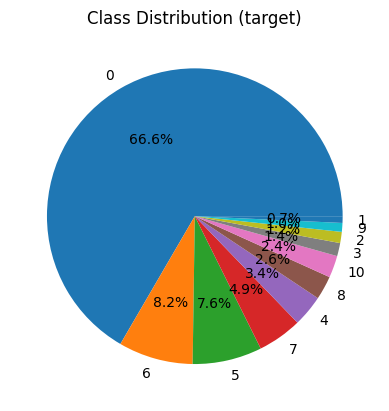

In [6]:
class_counts = original_dataset['target'].value_counts()
colors = plt.cm.Pastel1.colors[:len(class_counts)]
plt.figure()
plt.pie(class_counts.values, labels=class_counts.index, autopct='%1.1f%%', colors=colors)
plt.title('Class Distribution (target)')
plt.show()

Analyze the dataset

In [7]:
original_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 22 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   id                    1048575 non-null  int64  
 1   title                 1048562 non-null  object 
 2   vote_average          1048575 non-null  float64
 3   vote_count            1048575 non-null  int64  
 4   status                1048575 non-null  object 
 5   release_date          866758 non-null   object 
 6   revenue               1048575 non-null  int64  
 7   runtime               1048575 non-null  int64  
 8   adult                 1048575 non-null  bool   
 9   budget                1048575 non-null  int64  
 10  imdb_id               560572 non-null   object 
 11  original_language     1048575 non-null  object 
 12  original_title        1048562 non-null  object 
 13  overview              832751 non-null   object 
 14  popularity            1048575 non-

Delete all columns containing text attributes in order to continue using standard approaches for tabular data.

In [8]:
original_dataset.drop(
    columns=[
        "title",
        "imdb_id",
        "original_language",
        "original_title",
        "overview",
        "tagline",
        "genres",
        "production_companies",
        "production_countries",
        "spoken_languages",
        "keywords"
    ],
    inplace=True
)

In [9]:
original_dataset.head(10)

,id,vote_average,vote_count,status,release_date,revenue,runtime,adult,budget,popularity,target
0,27205,8.364,34495,Released,7/15/2010,825532764,148,False,160000000,83.952,8
1,157336,8.417,32571,Released,11/5/2014,701729206,169,False,165000000,140.241,8
2,155,8.512,30619,Released,7/16/2008,1004558444,152,False,185000000,130.643,8
3,19995,7.573,29815,Released,12/15/2009,2923706026,162,False,237000000,79.932,7
4,24428,7.710,29166,Released,4/25/2012,1518815515,143,False,220000000,98.082,7
5,293660,7.606,28894,Released,2/9/2016,783100000,108,False,58000000,72.735,7
6,299536,8.255,27713,Released,4/25/2018,2052415039,149,False,300000000,154.340,8
7,550,8.438,27238,Released,10/15/1999,100853753,139,False,63000000,69.498,8
8,118340,7.906,26638,Released,7/30/2014,772776600,121,False,170000000,33.255,7
9,680,8.488,25893,Released,9/10/1994,213900000,154,False,8500000,74.862,8


Show columns with `nan` values 

In [10]:
original_dataset.isna().sum()

id                   0
vote_average         0
vote_count           0
status               0
release_date    181817
revenue              0
runtime              0
adult                0
budget               0
popularity           0
target               0
dtype: int64

Remove duplicates and omissions

In [11]:
original_dataset.duplicated().sum()

np.int64(373)

In [12]:
original_dataset.dropna(inplace=True)
original_dataset.drop_duplicates(inplace=True)

In [13]:
original_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 866602 entries, 0 to 1048573
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            866602 non-null  int64  
 1   vote_average  866602 non-null  float64
 2   vote_count    866602 non-null  int64  
 3   status        866602 non-null  object 
 4   release_date  866602 non-null  object 
 5   revenue       866602 non-null  int64  
 6   runtime       866602 non-null  int64  
 7   adult         866602 non-null  bool   
 8   budget        866602 non-null  int64  
 9   popularity    866602 non-null  float64
 10  target        866602 non-null  int64  
dtypes: bool(1), float64(2), int64(6), object(2)
memory usage: 73.6+ MB


## Analysis of numeric features and the target variable.

### Target Variable

Build distribution of the target variable

In [14]:
original_dataset['target'].value_counts()

target
0     523644
6      84700
5      79056
7      50079
4      35767
8      26281
10     22563
3      14877
2      12613
9       9583
1       7439
Name: count, dtype: int64

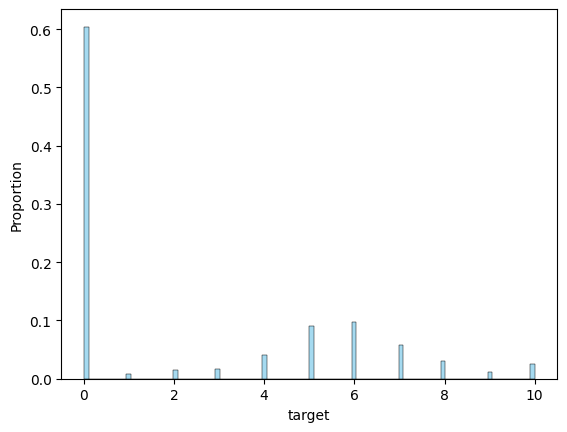

In [15]:
sns.histplot(data=original_dataset, x='target', stat='proportion', color='skyblue')
plt.show()

The target variable contains a serious imbalance. Let's perform a simple balancing of the dataset, reducing the volume of classes 0, 5, 6 to 25,000 objects (since in this laboratory the requirement for the volume of the dataset is >100,000 objects and we can sacrifice the volume in order not to create a large amount of artificial data).

In [16]:
target_counts = [0, 5, 6]
new_indices = []

for target in target_counts:
    indices = np.where(original_dataset["target"] == target)[0]
    sampled_indices = np.random.choice(indices, 25000, replace=False)
    new_indices.extend(sampled_indices)

new_indices = np.array(new_indices)

In [17]:
mask = ~original_dataset["target"].isin(target_counts)
train_data = pd.concat([original_dataset.iloc[new_indices], original_dataset[mask]])
train_data.reset_index(drop=True, inplace=True)

In [18]:
original_dataset["target"].value_counts()

target
0     523644
6      84700
5      79056
7      50079
4      35767
8      26281
10     22563
3      14877
2      12613
9       9583
1       7439
Name: count, dtype: int64

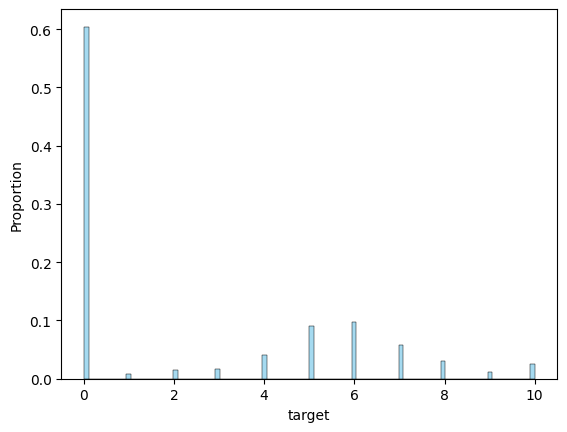

In [19]:
sns.histplot(data=original_dataset, x='target', stat='proportion', color='skyblue')
plt.show()

As a result, we have a more uniform distribution of features.

## Feature `adult`

In [20]:
original_dataset["adult"].value_counts()

adult
False    780437
True      86165
Name: count, dtype: int64

Convert the feature to `int` type

In [21]:
original_dataset['adult'] = original_dataset['adult'].astype(int)

## Feature `status`

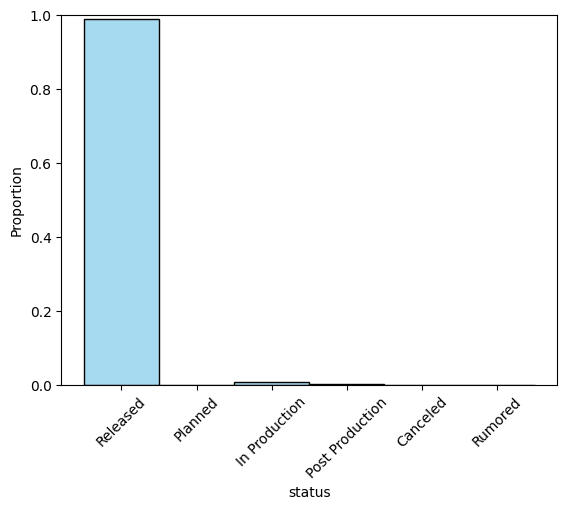

In [22]:
sns.histplot(data=original_dataset, x='status', stat='proportion', color='skyblue')
plt.ylim((0,1))
plt.xticks(rotation=45)
plt.show()

Despite the fact that the distribution of the feature is uneven, we will leave it in order to further analyze its significance.

## Feature `release_date`

In [23]:
original_dataset["release_date"].value_counts()

release_date
1/1/2006      3202
1/1/2010      2997
1/1/2011      2975
1/1/2009      2961
1/1/2007      2958
              ... 
7/27/1907        1
6/15/1907        1
9/21/1907        1
7/31/1907        1
11/30/1907       1
Name: count, Length: 42375, dtype: int64

Unifying the date type

In [24]:
original_dataset["release_date"] = pd.to_datetime(original_dataset["release_date"], errors="coerce")
original_dataset["release_date"].isnull().sum()
original_dataset.dropna(inplace=True)

In my opinion, the month and day of the film's release are mostly noise, so let's leave only the sign with the year of the film's release.

In [25]:
original_dataset["release_year"] = original_dataset["release_date"].dt.year
original_dataset.drop(columns="release_date", inplace=True)

# Model selection

In [26]:
#  Divide dataset into a training and a test sample, so that all KFold validation can be done on a small test sample, and the final model can be trained on a training one.
train_dataset, test_dataset = train_test_split(original_dataset, test_size=0.3, random_state=42)

Using the `KFold' (k=10) cross-validation, we select the model. We will use `OneHotEncoding` as a way to encode features.

| Models |
|----------|
| `LogisticRegression` |
| `DecisionTreeClassifier` |
| `RandomForestClassifier` |
| `GradientBoostingClassifier` |


In [27]:
x = test_dataset.drop(columns='target')
y = np.array(test_dataset['target'])

In [28]:
x.shape

(259390, 10)

In [29]:
models = {
    'LogisticRegression': lambda: LogisticRegression(max_iter=500),
    'DecisionTreeClassifier': DecisionTreeClassifier,
    'RandomForestClassifier': RandomForestClassifier,
    'GradientBoostingClassifier': GradientBoostingClassifier
}

metrics = {}

kf = KFold(n_splits=2, shuffle=True, random_state=42)

encoder_method = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
column_transformer = ColumnTransformer([
    ('ohe', encoder_method, ['status']),
], remainder="passthrough")

for train_index, val_index in kf.split(x):
    x_train, y_train = x.iloc[train_index, :], y[train_index]
    x_val, y_val = x.iloc[val_index, :], y[val_index]

    for model_name, model_creator in models.items():
        pipeline = Pipeline(steps=[
            ('ohe', column_transformer),
            ('scaling', StandardScaler()),
            ('model', model_creator())
        ])

        pipeline.fit(x_train, y_train)
        f1 = f1_score(y_val, pipeline.predict(x_val), average='weighted')

        if model_name not in metrics:
            metrics[model_name] = []
        metrics[model_name].append(f1)

In [30]:
for experiment in metrics:
    metrics[experiment]=np.mean(metrics[experiment])
pd.DataFrame.from_dict(metrics, orient='index').rename(columns={0: 'f1 score'}).sort_values(by='f1 score', ascending=False)

,f1 score
DecisionTreeClassifier,0.999985
GradientBoostingClassifier,0.999985
RandomForestClassifier,0.998237
LogisticRegression,0.973613


We will use 2 best models: `GradientBoostingClassifier` и `DecisionTreeClassifier`.

# Feature selection

In [31]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(sparse_output=False, handle_unknown="ignore"), ['status']),
], remainder="passthrough")
column_transformer.fit(x, y)
x = pd.DataFrame(column_transformer.transform(x), columns=column_transformer.get_feature_names_out())

In [32]:
x.shape

(259390, 15)

At the moment, we have quite a large number of signs. Let's try to select the most important features by the weights of the logistic regression.

In [33]:
pipeline = Pipeline(steps=[
    ('scaling', StandardScaler()),
    ('regression', LogisticRegression(max_iter=500))
])
pipeline.fit(x, y)
coef = pipeline.steps[1][1].coef_[0]

We visualize the absolute values of the weights of the logistic regression.

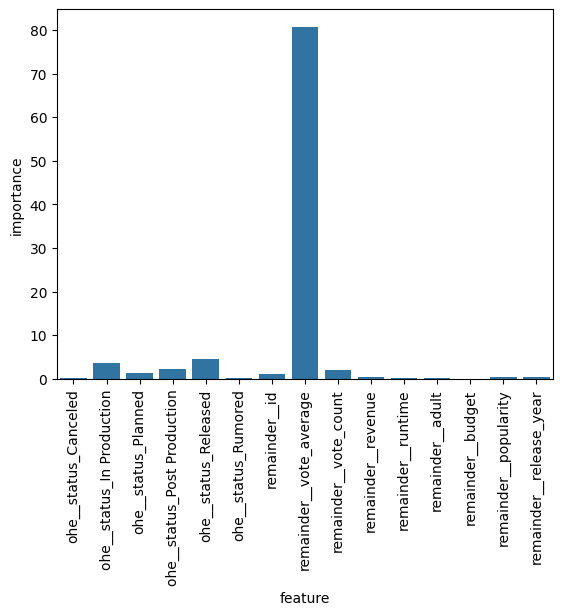

In [34]:
sns.barplot(data=pd.DataFrame.from_dict({'importance': np.abs(coef), 'feature': x.columns}), x='feature', y='importance')
plt.xticks(rotation=90)
plt.show()

We will select features that have $importance > C$, where $C$ is some kind of threshold. Using the `k-Fold' (k=10) cross-validation, we will find such a threshold.

In [ ]:
f1 = {i: [] for i in sorted(np.abs(coef))[:-1]}
kf = KFold(n_splits=10, shuffle=True, random_state=42)

for train_index, val_index in tqdm(kf.split(x)):
    for C in f1:
        X_train = x.iloc[train_index, np.abs(coef) > C]
        y_train = y[train_index]
        X_val = x.iloc[val_index, np.abs(coef) > C]
        y_val = y[val_index]

        pipeline = Pipeline(steps=[
            ('scaling', StandardScaler()),
            ('regression', LogisticRegression(max_iter=500, solver='lbfgs'))
        ])
        pipeline.fit(X_train, y_train)

        f1[C].append(f1_score(y_val, pipeline.predict(X_val), average='weighted'))

for C in f1:
    f1[C] = np.mean(f1[C])

f1 = pd.DataFrame.from_dict(f1, orient='index').reset_index().rename(columns={'index': 'C', 0: 'f2-score'})

print(f1)

2it [24:02, 724.02s/it]

In [ ]:
sns.lineplot(data=f1, x='C', y='f2-score')
plt.show()

It can be seen that at $0<C<0.3$ chaotic fluctuations occur. Let's take the threshold of $C=0.3$, after which the quality of the model begins to deteriorate.

In [ ]:
x = x.iloc[:, np.abs(coef)>0.3]

In [ ]:
x.columns

# Model training

Since we have selected the best models and selected the features, we can see what quality we get now.

In [ ]:
models = {
    'DecisionTreeClassifier': DecisionTreeClassifier,
    'GradientBoostingClassifier': GradientBoostingClassifier
}

metrics = {}

kf = KFold(n_splits=10, shuffle=True, random_state=42)
for train_index, val_index in kf.split(x):
    for model in models:
        X_train = x.iloc[train_index, :]
        y_train = y[train_index]
        X_val = x.iloc[val_index, :]
        y_val = y[val_index]

        pipeline = Pipeline(steps=[
            ('scaling', StandardScaler()),
            ('classifier', models[model]())
        ])
        pipeline.fit(X_train, y_train)

        if model not in metrics:
            metrics[model] = []
        
        f1 = f1_score(y_val, pipeline.predict(X_val), average='weighted')
        metrics[model].append(f1)

In [ ]:
for experiment in metrics:
    metrics[experiment]=np.mean(metrics[experiment])
pd.DataFrame.from_dict(metrics, orient='index').rename(columns={0: 'f1 score'}).sort_values(by='f1 score', ascending=False)

# We are training the final GradientBoostingClassifier model, which proved to be the best

In [ ]:
final_train_dataset, final_test_dataset = train_test_split(train_dataset, test_size=0.2, random_state=42)

x_train = final_train_dataset.drop(columns='target')
y_train = np.array(final_train_dataset['target'])

x_test = final_test_dataset.drop(columns='target')
y_test = np.array(final_test_dataset['target'])

In [ ]:
x_train.head()

In [ ]:
encoder_method = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
column_transformer = ColumnTransformer([
    ('ohe', encoder_method, ['status']),
], remainder="passthrough")
column_transformer.fit(x_train, y_train)
x_train = pd.DataFrame(column_transformer.transform(x_train), columns=column_transformer.get_feature_names_out())

x_test = pd.DataFrame(column_transformer.transform(x_test), columns=column_transformer.get_feature_names_out())

In [ ]:
x_train.head()

In [ ]:
columns_to_remove = ["ohe__status_In Production", "ohe__status_Planned", "ohe__status_Rumored", "remainder__runtime", "remainder__adult", "remainder__release_year"]
x_train.drop(columns=columns_to_remove, inplace=True)
x_test.drop(columns=columns_to_remove, inplace=True)

In [ ]:
scaler = StandardScaler()
scaler.fit(x_train)

x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [ ]:
classifier = GradientBoostingClassifier()

classifier.fit(x_train_scaled, y_train)

In [ ]:
import os

encoder_filename = 'model/encoder.joblib'
scaler_filename = 'model/scaler.joblib'
model_filename = 'model/classifier.joblib'

if not os.path.exists('model'):
    os.makedirs('model')

joblib.dump(column_transformer, encoder_filename)
joblib.dump(scaler, scaler_filename)
joblib.dump(classifier, model_filename)

In [ ]:
f1 = f1_score(y_test, classifier.predict(x_test_scaled), average='weighted')
print(f"F1 Score: {f1}")